Code up a momentum strategy for SPY (using the data provided) as discussed in the attached "Case Study Momentum Strategy" document.

For predictor variables, choose lagged 1W, 2W, 1M and 2M returns of S&P and 3 other Indices (Any ticker in the directory beginning with the letter "X" is an index; so XLK is the technology sector index), yielding a total of 16 variables. To calibrate the model, we used a rolling window of 100 trading days (~); re-calibration is performed once every month. The model will be used to predict the next day's return for S&P. If the next day predicted return is positive, you go long the asset, otherwise you short it.

Evaluate the following learning algorithms:

Ordinary Least Squares, Lasso, Ridge, ElasticNet, and kNN

In [61]:
# standard magic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os


# 1. Load and choose data
1. Load all indices, choose three 
2. While loading, compute lagged returns
3. Only use data with non-nan rows (discard first 60 rows)

In [63]:
# func for automating loading, returns calculatino, and train/test spliting process
def loadLagReturns(ticker, root='C:/Users/Allen Tao/Desktop/FRE 7773/Assignments/A1/A1 Data/', lag=[5, 10, 20, 40]):
    '''
    Automate data loading process: loading, compute returns with laggs
    Input: ticker(str), root(default to data storage folder), lag (default to (1w=5d, 2w=10d, 1mo=20d, 2mo=40d))
    output: one df of lagged returns for each ticker
    '''
    # load spy
    df = pd.read_csv(root + f'{ticker}.csv', index_col='Dt', parse_dates=True)
    
    def lagRet(dataf, l):
        '''
        compute returns with laggs
        input: dataf(df), l(array of laggs as number of days)
        output: one df of lagged returns for each dataf
        '''
        for n in l:
            dataf[f'R{n}'] = df['Close'] / df.shift(n)['Close'] - 1
        return dataf
        
    # compute lagged returns
    df = lagRet(df, lag)
    
    # drop data containing nan
    df.dropna(axis=0, inplace=True)
    
    return df


choose index:
XLB (materials), XLE (energy), XLF (finance)

In [64]:
# get array of xl indices
root = 'C:/Users/Allen Tao/Desktop/FRE 7773/Assignments/A1/A1 Data/'
f_list = [s.replace('.csv', '') for s in os.listdir(root)]

for name in f_list:
    if name[:2] == 'XL' or name == 'SPY':
        locals()[f'{name}'] = loadLagReturns(name)

XL_list = [XLB, XLE, XLF, XLI, XLK, XLP, XLRE, XLU, XLV, XLY]


form features and targets
Note: y is shifted back one day, so that the data is next days return. 

In [65]:
# prep x and y, match column.
col = ['R5', 'R10', 'R20', 'R40']
x = pd.concat([SPY[col], XLB[col], XLE[col], XLF[col]], axis=1).iloc[:-1, :]
x.set_axis(['SPY5', 'SPY10', 'SPY20', 'SPY40', 'XLB5', 'XLB10', 'XLB20', 'XLB40', 'XLE5', 'XLE10', 'XLE20', 'XLE40', 
            'XLF5', 'XLF10', 'XLF20', 'XLF40', ], axis=1, inplace=True)

# note: y is next day's return -> find today's return, shift, drop 2 days
y = pd.DataFrame(SPY['Close'] / SPY.shift(1)['Close'] - 1).shift(-1).iloc[:-1, :]
y

,Close
Dt,
2018-02-26,-0.012487
2018-02-27,-0.010130
2018-02-28,-0.014541
2018-03-01,0.005155
2018-03-02,0.011558
...,...
2018-12-21,-0.026423
2018-12-24,0.050525
2018-12-26,0.007677


check scales of the variables

In [66]:
x.describe()


,SPY5,SPY10,SPY20,SPY40,XLB5,XLB10,XLB20,XLB40,XLE5,XLE10,XLE20,XLE40,XLF5,XLF10,XLF20,XLF40
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,-0.002358,-0.003351,-0.004145,-0.005004,-0.004486,-0.008133,-0.014210,-0.027149,-0.003845,-0.006333,-0.010846,-0.020161,-0.004899,-0.008680,-0.014246,-0.021565
std,0.022014,0.029421,0.035359,0.045217,0.026918,0.036487,0.044556,0.046128,0.030492,0.042769,0.058669,0.086973,0.026182,0.034885,0.043529,0.044928
min,-0.082315,-0.112584,-0.109820,-0.132331,-0.076804,-0.090490,-0.141132,-0.154078,-0.116798,-0.146345,-0.157565,-0.196178,-0.096536,-0.119013,-0.141923,-0.129536
25%,-0.013034,-0.014981,-0.029743,-0.041649,-0.021107,-0.031323,-0.037554,-0.057381,-0.020821,-0.027439,-0.038462,-0.099399,-0.021413,-0.028986,-0.038420,-0.053805
50%,0.001087,0.003115,0.006675,0.008692,-0.002940,-0.004470,-0.004396,-0.022184,0.001897,-0.002172,-0.009091,-0.015171,-0.002833,-0.004261,-0.005169,-0.020516
75%,0.011929,0.015143,0.021694,0.030505,0.014048,0.014608,0.019267,0.008023,0.016001,0.021519,0.022186,0.024040,0.013499,0.014472,0.016696,0.013562
max,0.047104,0.062715,0.082444,0.075969,0.066614,0.108691,0.067921,0.074259,0.066056,0.092038,0.130112,0.181818,0.051805,0.081220,0.093520,0.079305


In [67]:
y.describe()


,Close
count,213.000000
mean,-0.000444
std,0.010428
min,-0.032402
25%,-0.005224
50%,0.000034
75%,0.005032
max,0.050525


x, y are on matching scales. Carry on implementing the model

# 2. Split data
**recalibration split**
(has to do this manually cuz sklearn.model_selection.TimeSeriesSplit doesnot support per month calibration)
1. window size = 100 train + 20 test
2. groups seperated by 20 days
3. total number of groups = floor((213-120)/20) + 1 = 5
4. ^ this means we kinda have to discard the last 13 samples - that's fine.

**train-test split**
1. last twenty rows for each recalibration are test. first 100 train.

In [68]:
#recalibration split
x1 = x.iloc[:120, :]
x2 = x.iloc[20:140, :]
x3 = x.iloc[40:160, :]
x4 = x.iloc[60:180, :]
x5 = x.iloc[80:200, :]

y1 = y.iloc[:120, :]
y2 = y.iloc[20:140, :]
y3 = y.iloc[40:160, :]
y4 = y.iloc[60:180, :]
y5 = y.iloc[80:200, :]


In [69]:
# train test split function for each recalibration split
def trainTest(dataf):
    '''
    splits 100:20 train:test
    input: 1 data frame for each recalibraiton
    output: 2df as train, test
    '''
    train = dataf.iloc[:100, :]
    test = dataf.iloc[100:, :]
    return train, test

x1r, x1e = trainTest(x1)
x2r, x2e = trainTest(x2)
x3r, x3e = trainTest(x3)
x4r, x4e = trainTest(x4)
x5r, x5e = trainTest(x5)

y1r, y1e = trainTest(y1)
y2r, y2e = trainTest(y2)
y3r, y3e = trainTest(y3)
y4r, y4e = trainTest(y4)
y5r, y5e = trainTest(y5)

data = [[x1r, y1r, x1e, y1e], [x2r, y2r, x2e, y2e], [x3r, y3r, x3e, y3e], [x4r, y4r, x4e, y4e], [x5r, y5r, x5e, y5e]]


Ignored holiday and simplified date counting in this code for simplicity. Formal mometum and partitioning should include such consideration.

# 3. test models
1. for each model type, build 5 models using each recalibration pair
2. model types include: Ordinary Least Squares, Lasso (alpha = 0.001 or 0.05), Ridge, ElasticNet and kNN
3. use only the best out of 5 models from each model type to predict buy/sell for the entire dataset


**OLS**

In [70]:
# function that finds the best ols model
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
import math

def bestOLS(arr):
    '''
    a function that runs OLS on all five train-test recalibration pairs and returns the model with the least MSE
    input: array of arrays containing xtrain, ytrain, xtest, ytest
    output: the best OLS model (min MSE)
    '''
    count = -1
    best = 0
    mse = math.inf
    for l in arr:
        count += 1
        ols = linear_model.LinearRegression()
        ols.fit(l[0], l[1])
        yp = ols.predict(l[2])
        m = mean_squared_error(l[3], yp)
#         print(m)
        if m < mse:
            mse = m
            best = count
    ols.fit(arr[count][0], arr[count][1])
    return ols


In [71]:
# find the best ols model
ols = bestOLS(data)


**Lasso, alpha = 0.001 or 0.05**

Note: α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values: α = 0: The objective becomes same as simple linear regression 

source: 
https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

In [72]:
# function that finds the best Lasso alpha=0.001 model
from sklearn import linear_model

def bestLasso(arr, alp):
    '''
    a function that runs Lasso on all five train-test recalibration pairs and returns the model with the least MSE
    input: array of arrays containing xtrain, ytrain, xtest, ytest; float alpha
    output: the best Lasso with given alpha (min mse)
    '''
    count = -1
    best = 0
    mse = math.inf
    for l in arr:
        count += 1
        lasso = linear_model.Lasso(alpha=alp)
        lasso.fit(l[0], l[1])
        yp = lasso.predict(l[2])
        m = mean_squared_error(l[3], yp)
        if m < mse:
            mse = m
            best = count
    lasso.fit(arr[count][0], arr[count][1])
    return lasso


In [73]:
# find the best lasso models
lasso001 = bestLasso(data, 0.001)
lasso05 = bestLasso(data, 0.05)


**Lasso, gridsearch for alpha**

test alpha = 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 50, 100]}

for l in data:
    grid = GridSearchCV(linear_model.Lasso(), param_grid, cv=5)
    _ = grid.fit(l[0], l[1])
    grid.best_params_
    

{'alpha': 0.001}

{'alpha': 0.001}

{'alpha': 0.001}

{'alpha': 0.001}

{'alpha': 0.001}

it's obvious that models with smaller alpha (closer to ols) gives better results. 

**Ridge, gridsearch for alpha**

test alpha = 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 50, 100

In [75]:
from sklearn.linear_model import Ridge

for l in data:
    grid = GridSearchCV(Ridge(), param_grid, cv=5)
    _ = grid.fit(l[0], l[1])
    grid.best_params_
    

{'alpha': 0.1}

{'alpha': 10}

{'alpha': 1}

{'alpha': 100}

{'alpha': 100}

larger alpha is often preferred

use alpha = 100

In [76]:
def bestRidge(arr, alp):
    '''
    a function that runs Ridge on all five train-test recalibration pairs and returns the model with the least MSE
    input: array of arrays containing xtrain, ytrain, xtest, ytest; float alpha
    output: the best ridge with given alpha (min mse)
    '''
    count = -1
    best = 0
    mse = math.inf
    for l in arr:
        count += 1
        ridge = linear_model.Ridge(alpha=alp)
        ridge.fit(l[0], l[1])
        yp = ridge.predict(l[2])
        m = mean_squared_error(l[3], yp)
        if m < mse:
            mse = m
            best = count
    ridge.fit(arr[count][0], arr[count][1])
    return ridge


In [77]:
# find the best ridge model
ridge = bestRidge(data, 100)


**ElasticNet, gridsearch for alpha**

test alpha = 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1

In [78]:
from sklearn.linear_model import ElasticNet

for l in data:
    grid = GridSearchCV(ElasticNet(), param_grid, cv=5)
    _ = grid.fit(l[0], l[1])
    grid.best_params_
    

{'alpha': 0.001}

{'alpha': 0.001}

{'alpha': 0.001}

{'alpha': 0.001}

{'alpha': 0.001}

it's obvious that models with smaller alpha (closer to ols) gives better results. For fun, I changed this to an alpha of 0.05 to get variation in the final results

In [79]:
def bestEN(arr, alp):
    '''
    a function that runs ElasticNet on all five train-test recalibration pairs and returns the model with the least MSE
    input: array of arrays containing xtrain, ytrain, xtest, ytest; float alpha
    output: the best ElasticNet with given alpha (min mse)
    '''
    count = -1
    best = 0
    mse = math.inf
    for l in arr:
        count += 1
        en = ElasticNet(alpha=alp)
        en.fit(l[0], l[1])
        yp = en.predict(l[2])
        m = mean_squared_error(l[3], yp)
        if m < mse:
            mse = m
            best = count
    en.fit(arr[count][0], arr[count][1])
    return en


In [80]:
# find the best ElasticNet model
en = bestEN(data, 0.05)


**kNN, gridsearch for n_neighbors, leaf_size, p**
1. make y discrete to make kNN work
2. grid search
3. find best model

transform y

In [81]:
z = y.copy(deep=True)
add = []

for n in z.index:
    if z['Close'][n] > 0:
        add.append(1)
    else:
        add.append(0)
z.insert(1, 'P/L', add, True)

yb1 = z.iloc[:120, 1:]
yb2 = z.iloc[20:140, 1:]
yb3 = z.iloc[40:160, 1:]
yb4 = z.iloc[60:180, 1:]
yb5 = z.iloc[80:200, 1:]

yb1r, yb1e = trainTest(yb1)
yb2r, yb2e = trainTest(yb2)
yb3r, yb3e = trainTest(yb3)
yb4r, yb4e = trainTest(yb4)
yb5r, yb5e = trainTest(yb5)

data2 = [[x1r, yb1r, x1e, yb1e], [x2r, yb2r, x2e, yb2e], [x3r, yb3r, x3e, yb3e], [x4r, yb4r, x4e, yb4e], [x5r, yb5r, x5e, yb5e]]

In [82]:
from sklearn.neighbors import KNeighborsClassifier

# fk warnings
import warnings
warnings.filterwarnings('ignore')

param_grid2 = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10], 'leaf_size':[5, 10, 15, 30], 'p': [1, 2]}

for l in data2:
    grid = GridSearchCV(KNeighborsClassifier(), param_grid2, cv=5)
    _ = grid.fit(l[0], np.array(l[1]))
    grid.best_params_

{'leaf_size': 5, 'n_neighbors': 8, 'p': 2}

{'leaf_size': 5, 'n_neighbors': 9, 'p': 1}

{'leaf_size': 5, 'n_neighbors': 7, 'p': 2}

{'leaf_size': 5, 'n_neighbors': 5, 'p': 1}

{'leaf_size': 5, 'n_neighbors': 5, 'p': 1}

small leaf size preferred, neighbour = 5 is hopefully ideal? p = 1 might be better.

In [83]:
def bestKNN(arr, nn, ls, p):
    '''
    a function that runs kNN on all five train-test recalibration pairs and returns the model with the least MSE
    input: array of arrays containing xtrain, ytrain, xtest, ytest; float 
    output: the best kNN with given parameters (min difference)
    '''
    count = -1
    best = 0
    mse = math.inf
    for l in arr:
        count += 1
        knn = KNeighborsClassifier(n_neighbors=nn, leaf_size=ls, p=p)
        knn.fit(l[0], l[1])
        yp = knn.predict(l[2])
        m = mean_squared_error(l[3], yp)
        if m < mse:
            mse = m
            best = count
    knn.fit(arr[count][0], arr[count][1])
    return knn


In [84]:
# find the best kNN model
knn = bestKNN(data2, 5, 5, 1)

# Predict next day's S&P return
1. predict for all data available using the best chosen models
2. generate long/short decision
3. calculate culmulative asset based on L/S decision
4. calculate culmulative asset based on actual S&P return
5. plot results

put all prediction from best models into pred

In [85]:
# compile all predictions
models = [ols, lasso001, lasso05, ridge, en, knn]
p = {}
for m in models:
    p[m] = m.predict(x).reshape(-1, 1).ravel()

pred = pd.DataFrame(p, index=x.index)
pred


,LinearRegression(),Lasso(alpha=0.001),Lasso(alpha=0.05),Ridge(alpha=100),ElasticNet(alpha=0.05),"KNeighborsClassifier(leaf_size=5, p=1)"
Dt,,,,,,
2018-02-26,0.013851,0.000099,0.000099,0.000110,0.000099,1
2018-02-27,0.013062,0.000099,0.000099,0.000109,0.000099,1
2018-02-28,0.011091,0.000099,0.000099,0.000109,0.000099,1
2018-03-01,0.007863,0.000099,0.000099,0.000110,0.000099,1
2018-03-02,0.005506,0.000099,0.000099,0.000109,0.000099,1
...,...,...,...,...,...,...
2018-12-21,0.014735,0.000099,0.000099,0.000119,0.000099,0
2018-12-24,0.018008,0.000099,0.000099,0.000122,0.000099,0
2018-12-26,0.014835,0.000099,0.000099,0.000117,0.000099,0


In [86]:
pred.describe()

,LinearRegression(),Lasso(alpha=0.001),Lasso(alpha=0.05),Ridge(alpha=100),ElasticNet(alpha=0.05),"KNeighborsClassifier(leaf_size=5, p=1)"
count,213.000000,2.130000e+02,2.130000e+02,213.000000,2.130000e+02,213.000000
mean,-0.000855,9.944140e-05,9.944140e-05,0.000100,9.944140e-05,0.530516
std,0.007364,3.803647e-19,3.803647e-19,0.000008,3.803647e-19,0.500244
min,-0.017578,9.944140e-05,9.944140e-05,0.000082,9.944140e-05,0.000000
25%,-0.005324,9.944140e-05,9.944140e-05,0.000095,9.944140e-05,0.000000
50%,-0.000274,9.944140e-05,9.944140e-05,0.000099,9.944140e-05,1.000000
75%,0.003394,9.944140e-05,9.944140e-05,0.000104,9.944140e-05,1.000000
max,0.025859,9.944140e-05,9.944140e-05,0.000122,9.944140e-05,1.000000


Note that the predictions provided by lasso and elasticnet are very similar, probs due to the very low alpha value.

make long/short decisions: if positive return, long, otherwise short

In [87]:
# make long/short decisions
ls = pred.copy(deep=True)

for m in ls:
    for n in ls.index:
        if ls[m][n] > 0:
            ls[m][n] = 1
        else:
            ls[m][n] = -1


In [88]:
ls.describe()


,LinearRegression(),Lasso(alpha=0.001),Lasso(alpha=0.05),Ridge(alpha=100),ElasticNet(alpha=0.05),"KNeighborsClassifier(leaf_size=5, p=1)"
count,213.000000,213.0,213.0,213.0,213.0,213.000000
mean,-0.023474,1.0,1.0,1.0,1.0,0.061033
std,1.002080,0.0,0.0,0.0,0.0,1.000487
min,-1.000000,1.0,1.0,1.0,1.0,-1.000000
25%,-1.000000,1.0,1.0,1.0,1.0,-1.000000
50%,-1.000000,1.0,1.0,1.0,1.0,1.000000
75%,1.000000,1.0,1.0,1.0,1.0,1.000000
max,1.000000,1.0,1.0,1.0,1.0,1.000000


plot buy/sell decisions over the year

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

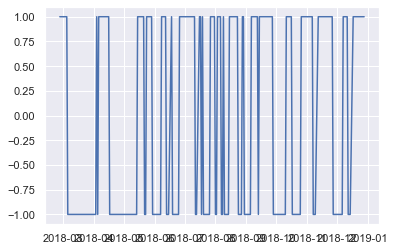

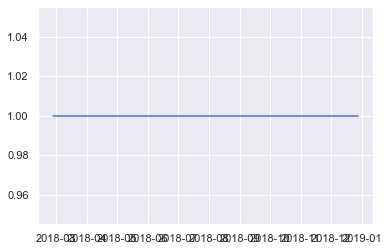

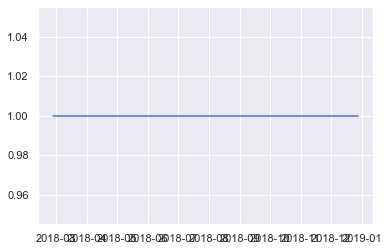

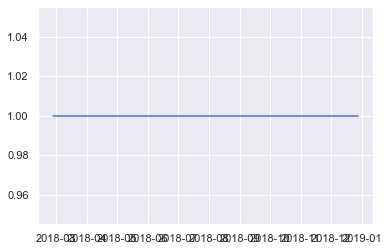

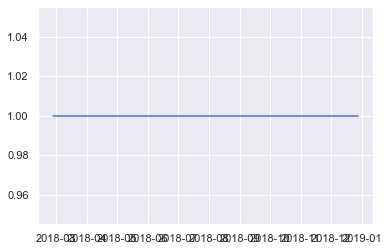

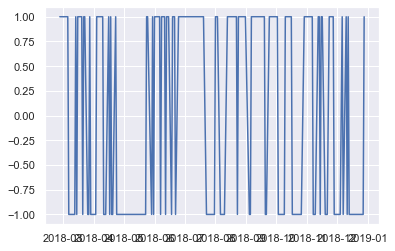

In [89]:
for i in range(ls.shape[1]):
    plt.figure(i)
    plt.plot(ls.iloc[:, i])

Clearly lasso, ridge, elastic nets are not ideal for this prediction.

**calculate cumulative returns based on l/s decisions**
1. multiply each long/short decision by the day's actual return to get the day's investment return
2. calculate culmulative return

In [90]:
cr = ls.copy(deep=True)

# y, but not shifted one day:
ret = pd.DataFrame(SPY['Close'] / SPY.shift(1)['Close'] - 1).iloc[:-1, :]
ret.iloc[0] = 0
ret


,Close
Dt,
2018-02-26,0.000000
2018-02-27,-0.012487
2018-02-28,-0.010130
2018-03-01,-0.014541
2018-03-02,0.005155
...,...
2018-12-21,-0.026176
2018-12-24,-0.026423
2018-12-26,0.050525


In [91]:
# daily multiplier
dret = ret.copy(deep=True) + 1
dret.describe()


,Close
count,213.000000
mean,0.999515
std,0.010409
min,0.967598
25%,0.994776
50%,1.000000
75%,1.004929
max,1.050525


In [92]:
# cumulative return (actual)
dret['Cum'] = dret.Close.cumprod()
dret


,Close,Cum
Dt,,
2018-02-26,1.000000,1.000000
2018-02-27,0.987513,0.987513
2018-02-28,0.989870,0.977510
2018-03-01,0.985459,0.963296
2018-03-02,1.005155,0.968262
...,...,...
2018-12-21,0.973824,0.866139
2018-12-24,0.973577,0.843253
2018-12-26,1.050525,0.885858


'follow the index' investment looks kinda sad. cum ret is going down this year

In [93]:
# find daily return following ls predicted by models:
for c in ls:
    ls[c] = ret['Close'] * ls[c]
ls.describe()


,LinearRegression(),Lasso(alpha=0.001),Lasso(alpha=0.05),Ridge(alpha=100),ElasticNet(alpha=0.05),"KNeighborsClassifier(leaf_size=5, p=1)"
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,-0.000073,-0.000485,-0.000485,-0.000485,-0.000485,0.000881
std,0.010420,0.010409,0.010409,0.010409,0.010409,0.010383
min,-0.027359,-0.032402,-0.032402,-0.032402,-0.032402,-0.050525
25%,-0.005242,-0.005224,-0.005224,-0.005224,-0.005224,-0.003383
50%,0.000108,0.000000,0.000000,0.000000,0.000000,0.001255
75%,0.004928,0.004929,0.004929,0.004929,0.004929,0.005717
max,0.050525,0.050525,0.050525,0.050525,0.050525,0.032402


In [94]:
# similarly, find cumulative return following our strat
ls += 1

In [95]:
ls = ls.cumprod()

<AxesSubplot:xlabel='Dt'>

,SPY,LinearRegression(),Lasso(alpha=0.001),Lasso(alpha=0.05),Ridge(alpha=100),ElasticNet(alpha=0.05),"KNeighborsClassifier(leaf_size=5, p=1)"
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,0.987527,1.003998,0.987527,0.987527,0.987527,0.987527,0.974931
std,0.037530,0.030818,0.037530,0.037530,0.037530,0.037530,0.073710
min,0.843253,0.920585,0.843253,0.843253,0.843253,0.843253,0.883249
25%,0.963548,0.982422,0.963548,0.963548,0.963548,0.963548,0.927567
50%,0.985894,0.997931,0.985894,0.985894,0.985894,0.985894,0.951850
75%,1.011371,1.021912,1.011371,1.011371,1.011371,1.011371,0.987222
max,1.056423,1.093120,1.056423,1.056423,1.056423,1.056423,1.267436


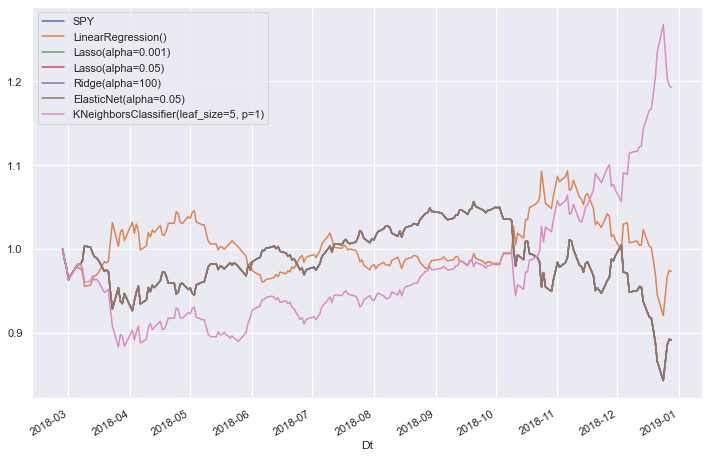

In [99]:
dret.rename(columns={'Close': 'Daily', 'Cum': 'SPY'}, inplace=True)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

# plot
returns = pd.concat([dret['SPY'], ls], axis=1)
returns.plot()
returns.describe()


Note: the cum ret of SPY, lassos, and elastic net completely overlap. This is because the models' (lasso, ridge, elastic net are l1, so neg vals are alwasy mirrored to pos vals) prediction didn't provide a predicted return that's less than zero, thus longs were always taken each day, resulting in the same final cum ret as the index.

In [101]:
annualized_ret = returns.iloc[-1].copy(deep=True)
annualized_ret = pow(annualized_ret, 252/213) - 1
annualized_ret

SPY                                      -0.127043
LinearRegression()                       -0.031552
Lasso(alpha=0.001)                       -0.127043
Lasso(alpha=0.05)                        -0.127043
Ridge(alpha=100)                         -0.127043
ElasticNet(alpha=0.05)                   -0.127043
KNeighborsClassifier(leaf_size=5, p=1)    0.231713
Name: 2018-12-28 00:00:00, dtype: float64

kNN provided the most impressive, and the only positive, annualized return.

In [104]:
sharpe = returns.iloc[-1].copy(deep=True)
sharpe = (sharpe - 1.281) / sharpe.std()
sharpe

SPY                                      -3.451399
LinearRegression()                       -2.726922
Lasso(alpha=0.001)                       -3.451399
Lasso(alpha=0.05)                        -3.451399
Ridge(alpha=100)                         -3.451399
ElasticNet(alpha=0.05)                   -3.451399
KNeighborsClassifier(leaf_size=5, p=1)   -0.783161
Name: 2018-12-28 00:00:00, dtype: float64

2.81% used as the riskfree rate (10 yr tbond rate) https://ycharts.com/indicators/10_year_treasury_rate|
terrible sharpe ratios. kNN was the best among all portfolios

Done!